## NAME - HIBAH MOHAMMED GHOUSE
##ZID- Z1945894


IMPORT LIBRARIES AND LOAD DATA


In [1]:
!pip install --upgrade xlrd

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

 
fileURL = "https://github.com/Hibah45/AppliedML/blob/main/AmesHousing.xls?raw=True"

d1 = pd.read_excel(fileURL)

target = d1['SalePrice']
data= d1.drop(['SalePrice','PID', 'Order'], axis=1)
df = data.select_dtypes(exclude=['object'])
continuous_features = list(df)


In [3]:
df.describe()

,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold
count,2930.000000,2440.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2907.000000,2929.000000,2929.000000,2929.000000,2929.000000,2930.000000,2930.000000,2930.000000,2930.000000,2928.000000,2928.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2771.000000,2929.000000,2929.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000
mean,57.387372,69.224590,10147.921843,6.094881,5.563140,1971.356314,1984.266553,101.896801,442.629566,49.722431,559.262547,1051.614544,1159.557679,335.455973,4.676792,1499.690444,0.431352,0.061134,1.566553,0.379522,2.854266,1.044369,6.443003,0.599317,1978.132443,1.766815,472.819734,93.751877,47.533447,23.011604,2.592491,16.002048,2.243345,50.635154,6.216041,2007.790444
std,42.638025,23.365335,7880.017759,1.411026,1.111537,30.245361,20.860286,179.112611,455.590839,169.168476,439.494153,440.615067,391.890885,428.395715,46.310510,505.508887,0.524820,0.245254,0.552941,0.502629,0.827731,0.214076,1.572964,0.647921,25.528411,0.760566,215.046549,126.361562,67.483400,64.139059,25.141331,56.087370,35.597181,566.344288,2.714492,1.316613
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,58.000000,7440.250000,5.000000,5.000000,1954.000000,1965.000000,0.000000,0.000000,0.000000,219.000000,793.000000,876.250000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1960.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,68.000000,9436.500000,6.000000,5.000000,1973.000000,1993.000000,0.000000,370.000000,0.000000,466.000000,990.000000,1084.000000,0.000000,0.000000,1442.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.000000,2.000000,480.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11555.250000,7.000000,6.000000,2001.000000,2004.000000,164.000000,734.000000,0.000000,802.000000,1302.000000,1384.000000,703.750000,0.000000,1742.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [4]:
d1.shape

(2930, 82)

In [5]:
df.head(5)

,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold
0,20,141.0,31770,6,5,1960,1960,112.0,639.0,0.0,441.0,1080.0,1656,0,0,1656,1.0,0.0,1,0,3,1,7,2,1960.0,2.0,528.0,210,62,0,0,0,0,0,5,2010
1,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1961.0,1.0,730.0,140,0,0,0,120,0,0,6,2010
2,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1958.0,1.0,312.0,393,36,0,0,0,0,12500,6,2010
3,20,93.0,11160,7,5,1968,1968,0.0,1065.0,0.0,1045.0,2110.0,2110,0,0,2110,1.0,0.0,2,1,3,1,8,2,1968.0,2.0,522.0,0,0,0,0,0,0,0,4,2010
4,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,1997.0,2.0,482.0,212,34,0,0,0,0,0,3,2010


In [6]:
categorical_data = data.select_dtypes(exclude=['int64','float64'])
cat_features = list(categorical_data)

## TASK 1- Univariate Analysis


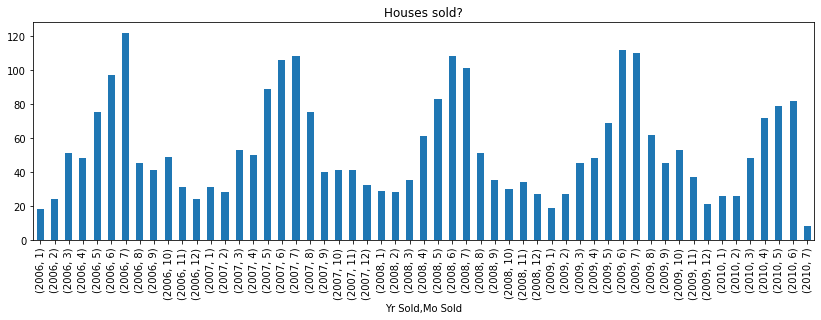

In [7]:
#Analysis of numeric values seperately 

d1.groupby(['Yr Sold','Mo Sold']).PID.count().plot(kind='bar', figsize=(14,4))
plt.title('Houses sold?')
plt.show() #houses sold peak in

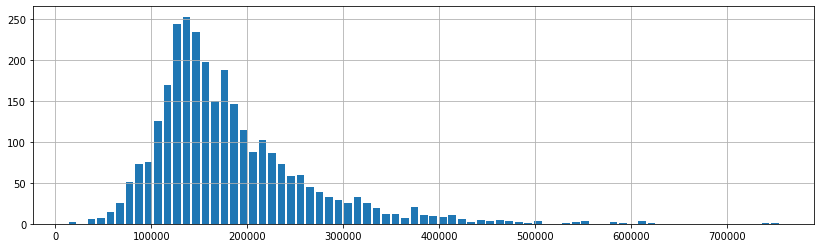

In [8]:
d1['SalePrice'].hist(bins=75, rwidth=.8, figsize=(14,4))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

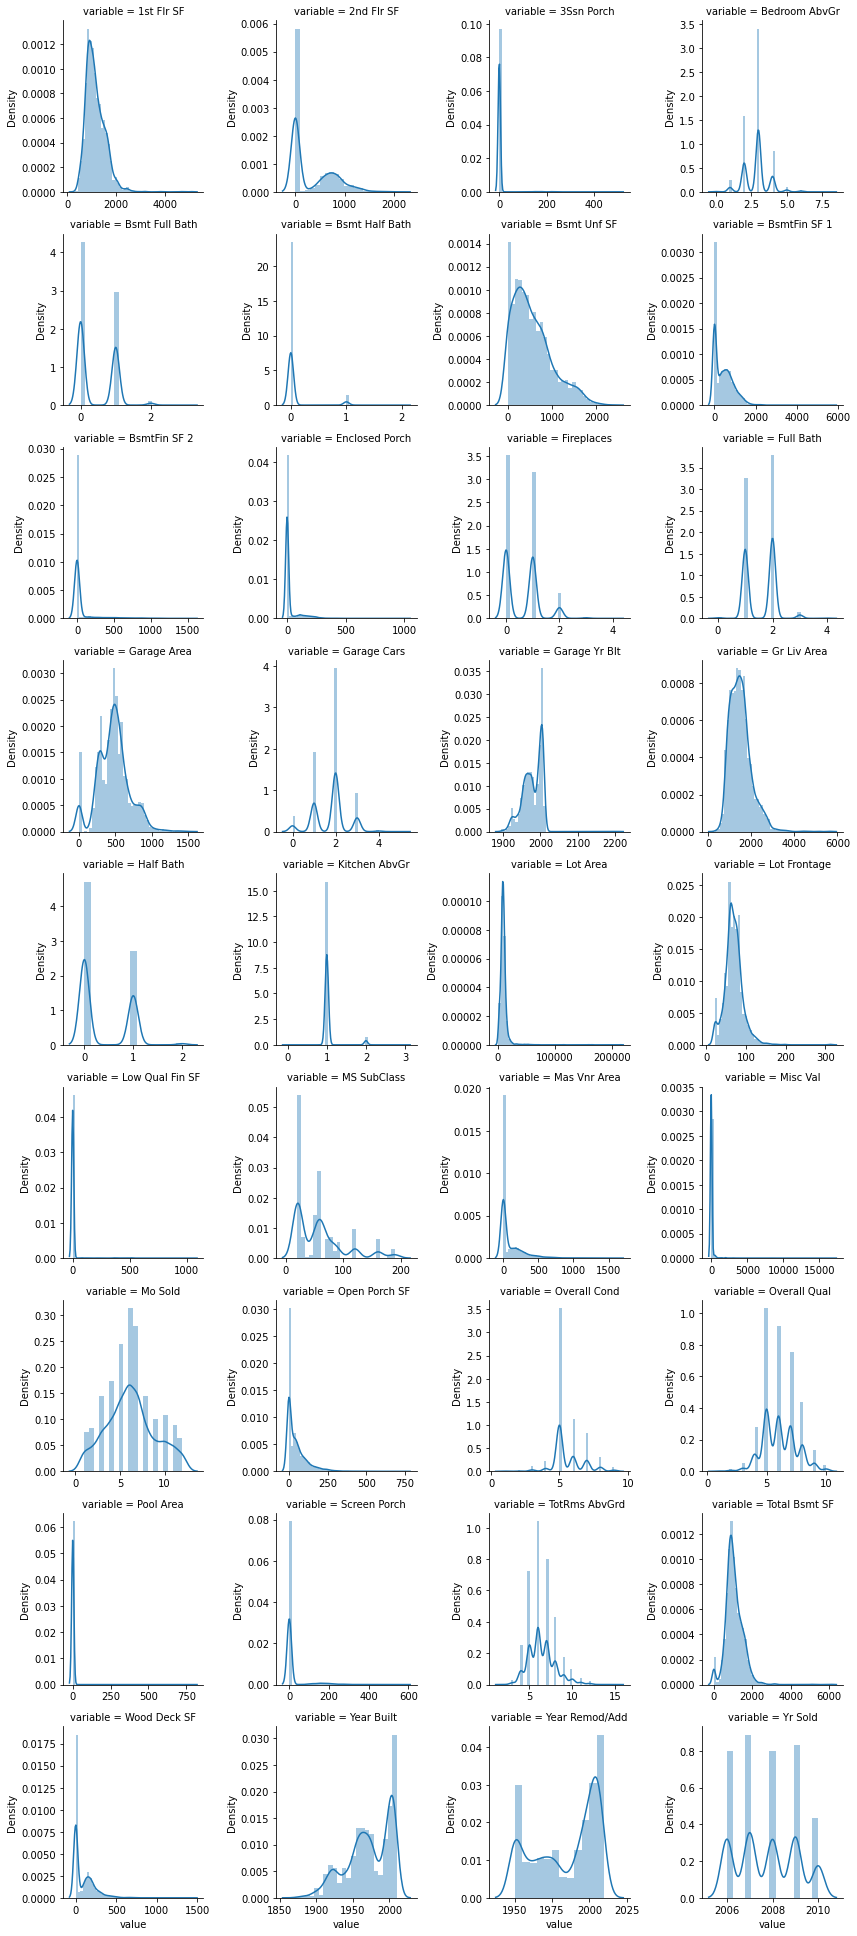

In [9]:
#Create facetgrid for analyis

x = pd.melt(df, value_vars=sorted(continuous_features))
y = sns.FacetGrid(x, col='variable', col_wrap=4, sharex=False, sharey=False)
y = y.map(sns.distplot, 'value')

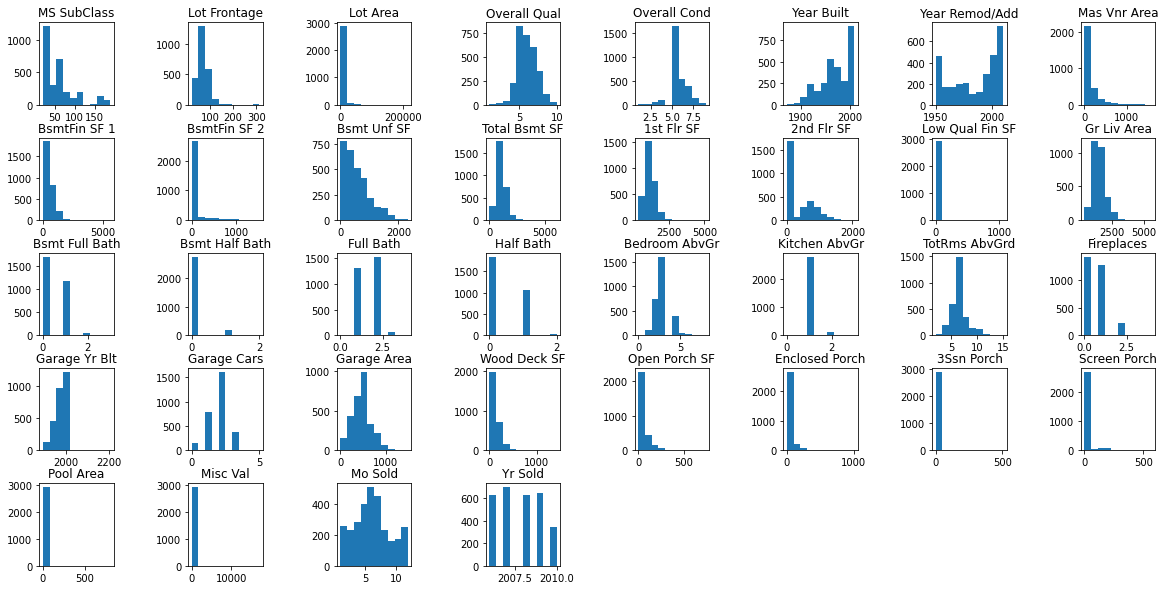

In [10]:
# Create histogram for each univariate distribution
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(hspace=0.4, wspace=1)
for i in range(len(df.columns)):
    uv = fig.add_subplot(5, 8, i+1)
    uv.hist(df.iloc[:,i])
    uv.set_title(list(df)[i])

OBSERVATION-
From the above plots, facetgrid shows that the data for some of the features is skewed which is also proven by histogram. There is an extremely skewed distributions for the numerical features as seen in histogram-Pool Area, Screen porch, LotArea, Misc Val, etc. which requires special treatment.
It may either be rescaled or transformed into categorical data as most of the values are same for them.


## TASK 2-Visualize the dependency of the target on each continuous feature

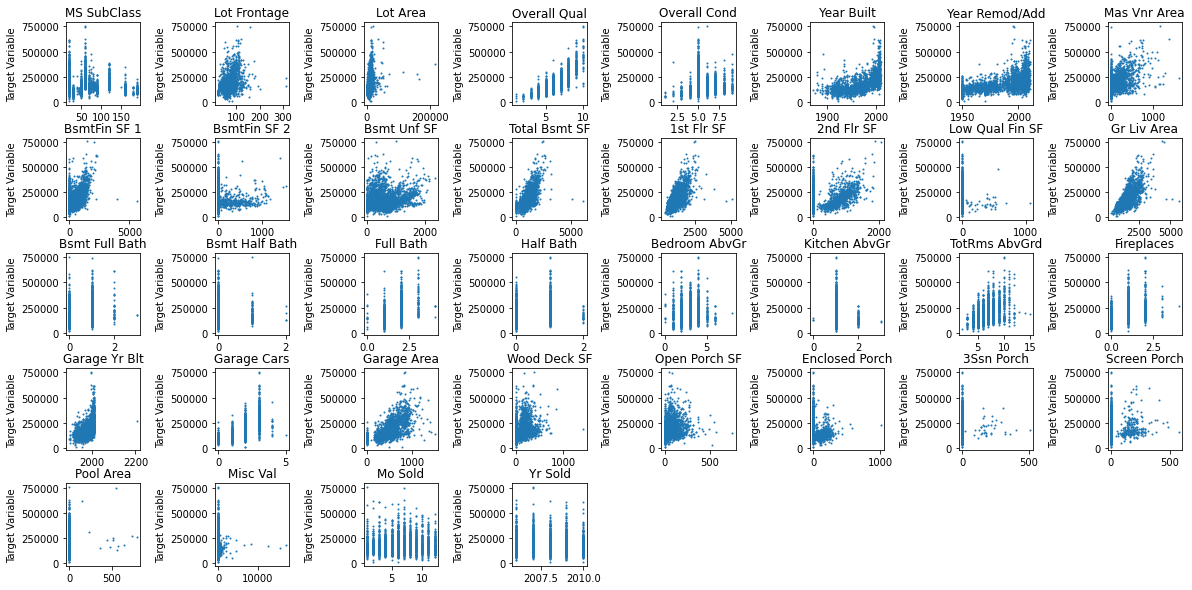

In [11]:
#Visualize the dependency of the target on each continuous feature
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(hspace=0.4, wspace=1)
for i in range(len(df.columns)):
    ax_sub = fig.add_subplot(5, 8, i+1)
    ax_sub.scatter(df.iloc[:,i],target,s=1)
    ax_sub.set_title(list(df)[i])
    ax_sub.set_ylabel("Target Variable")

For the above one as well, skewed distribution can be seen

## TASK 3- For each categorical (nominal) variable, cross-validate a Linear Regression model using just this variable (one-hot-encoded). Visualize the relationship of the categorical variables that provide the best R^2 value with the target.

In [12]:
#Preprocessing- remove the missed values and replace it
for feature in cat_features:
    nulls = data[feature].isnull().sum()
    if(nulls > 0):
        print(feature + " : " + str(nulls))

Alley : 2732
Mas Vnr Type : 23
Bsmt Qual : 80
Bsmt Cond : 80
Bsmt Exposure : 83
BsmtFin Type 1 : 80
BsmtFin Type 2 : 81
Electrical : 1
Fireplace Qu : 1422
Garage Type : 157
Garage Finish : 159
Garage Qual : 159
Garage Cond : 159
Pool QC : 2917
Fence : 2358
Misc Feature : 2824


In [13]:
print(len(cat_features))

43


In [14]:

r2_dict = {}

for cat_feature in cat_features:

    # extracting single column
    current_column = data[cat_feature].values.reshape(-1, 1); 

    # encoding extracted column using one hot encodder
    ohe=OneHotEncoder(categories='auto').fit(current_column)
    ohe_encoded_column=ohe.transform(current_column).toarray()

    l_reg = LinearRegression()

    avg_cross_val_score = cross_val_score(l_reg, ohe_encoded_column, target, cv=5, scoring='r2').mean()
    r2_dict[cat_feature] = avg_cross_val_score


sorted_dic = sorted(r2_dict.items(), key=lambda v: v[1], reverse=True)
print(sorted_dic[0:3])
# print(r2_dict)

[('Exter Qual', 0.4932714649557667), ('Garage Finish', 0.3004467261097029), ('Fireplace Qu', 0.2974319951407279)]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


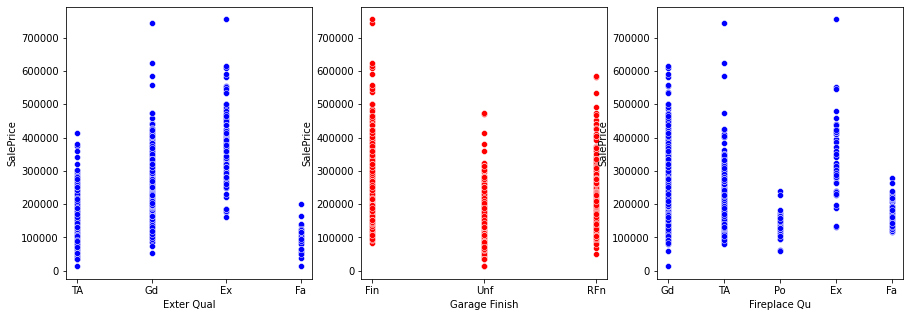

In [15]:
cat = categorical_data[['Exter Qual','Garage Finish','Fireplace Qu']]

# Plot scatterploy correspoinding to those features
f, axes = plt.subplots(1, 3,figsize=(15,5))
sns.scatterplot(cat['Exter Qual'], target,color='blue', ax=axes[0])
sns.scatterplot(cat['Garage Finish'],target, color='red', ax=axes[1])
sns.scatterplot(cat['Fireplace Qu'],target, color='blue', ax=axes[2])

## TASK 4 - Use ColumnTransformer and pipeline to encode nominal, ordinal, discrete variables. Evaluate Linear Regression (OLS), Ridge, Lasso and ElasticNet using cross-validation with the default parameters. Does scaling the data (within the pipeline) with StandardScaler help?

In [16]:
ohe = OneHotEncoder(handle_unknown='ignore')
scaler = StandardScaler()
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
ct = make_column_transformer((ohe, cat_features), (imputer, continuous_features), (scaler, continuous_features))

# initialize models here with required params

linearRegressionModel = LinearRegression()
ridgeModel = Ridge()
lassoModel = Lasso(alpha=0.1)
elasticNetModel = ElasticNet(random_state=0)

# dictionary of all models asked in question 
modelDict = {
    "linear regression" : linearRegressionModel,
    "ridge" : ridgeModel,
    "lasso" : lassoModel,
    "elastic net" : elasticNetModel 
}


# numeric transformer imputes missing numeric data with values using mean strategy then performance normalization using standardscaler
numeric_transformer1 = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")), 
    ("scaler", StandardScaler())
])

# WITHOUT STANDARD SCALER
# numeric transformer imputes missing numeric data with values using mean strategy then performance normalization using standardscaler
numeric_transformer2 = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean"))
])

# categorical transformer imputes NaN categorical values with string 'missing' which is treated as a new value 
# then applies OneHotEncoding on imputed data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])


# preprocessor applies above two transoformations in that order- with scaler
preprocessor1 = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer1, continuous_features),
        ("cat", categorical_transformer, cat_features),
    ]
)
  
# preprocessor without standard scaling
preprocessor2 = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer2, continuous_features),
        ("cat", categorical_transformer, cat_features),
    ]
)


In [17]:
def getCrossValScores(modelDict, X, Y, ct, cv=5, scoring="neg_mean_squared_error"):
    result = {}
    for model in modelDict:
        pipe = make_pipeline(ct, modelDict[model])
        meanCrossValScore = cross_val_score(pipe, data, target, cv=cv).mean()
        result[model] = meanCrossValScore
    return result;


In [18]:
# Without standard scaling the data - accuracy of lasso, linear, ridge and elasticnet
getCrossValScores(modelDict, data, target, preprocessor2)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 428326552375.22034, tolerance: 1413601571.5520763
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 488960839804.036, tolerance: 1533825143.5418239
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 472233997098.57806, tolerance: 1526703256.6343868
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38850947

{'elastic net': 0.8270856287253118,
 'lasso': 0.8524774986990751,
 'linear regression': 0.8546726374150007,
 'ridge': 0.7491382171593138}

In [19]:
# With standard scaling - checking whether there is any difference
getCrossValScores(modelDict, data, target, preprocessor1)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189501076770.5428, tolerance: 1413601571.5520763
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 238450298058.09113, tolerance: 1533825143.5418239
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 169836545024.29468, tolerance: 1526703256.6343868
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1294507

{'elastic net': 0.8339320723093235,
 'lasso': 0.8524854886868891,
 'linear regression': 0.8538572075933487,
 'ridge': 0.8644700301690103}

Observation- 

Scaling the data with standard scaler increases the accuracy most for the ridge regression. For others, the accuracy changes a little.

## TASK 5- Tune the parameters of the models using GridSearchCV. Do the results improve? Visualize the dependence of the validation score on the parameters for Ridge, Lasso and ElasticNet

In [20]:
# Performing grid search and returns the modelgrid object
def get_grid_object(modelPipeline, X, y, param_grid, cv=5, return_train_score=True):
    model_grid = GridSearchCV(modelPipeline, param_grid=param_grid, cv=cv, return_train_score=True)
    model_grid.fit(X, y)
    return model_grid

In [21]:
# Using GridSearch by performing hyperparams tuning and plotting the parameters
def tuneParams(modelPipeline, modelName, X, y, param_grid, alpha, cv, plt):

    model_grid = GridSearchCV(modelPipeline, param_grid=param_grid, cv=cv, return_train_score=True)
    model_grid.fit(X, y)

    print("best mean cross-validation score of {0}: {1}".format(modelName, model_grid.best_score_))
    print("best parameters of {0}: {1} ".format(modelName, model_grid.best_params_))
    print("test-set score of {0}: {1}".format(modelName, model_grid.score(X, y)))
    print("")

    train_scores_mean = model_grid.cv_results_["mean_train_score"]
    train_scores_std = model_grid.cv_results_["std_train_score"]
    test_scores_mean = model_grid.cv_results_["mean_test_score"]
    test_scores_std = model_grid.cv_results_["std_test_score"]

    
    plt.set_xlabel('$\\alpha$ (alpha)')
    plt.set_ylabel('Score')
    plt.semilogx(alpha, train_scores_mean, label='Mean Train score',
                color='black')

    plt.semilogx(alpha, test_scores_mean,
                label='Mean Test score', color='red')

    plt.fill_between(alpha,
                        test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std,
                        alpha=0.2,
                        color='lightblue')

    plt.legend(loc='best')


best mean cross-validation score of Ridge: 0.8413212021107069
best parameters of Ridge: {'ridge__alpha': 10} 
test-set score of Ridge: 0.9190990458421298

best mean cross-validation score of Lasso: 0.7274196417756887
best parameters of Lasso: {'lasso__alpha': 1.0} 
test-set score of Lasso: 0.8662855780185543



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8285200868.955261, tolerance: 1101557990.5634878
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1571402980.3691406, tolerance: 1021374721.1038481
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1355905472.2009277, tolerance: 1043585716.0234337
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1295441

best mean cross-validation score of ElasticNet: 0.8415900504061847
best parameters of ElasticNet: {'elastic__alpha': 0.01} 
test-set score of ElasticNet: 0.919227953923501



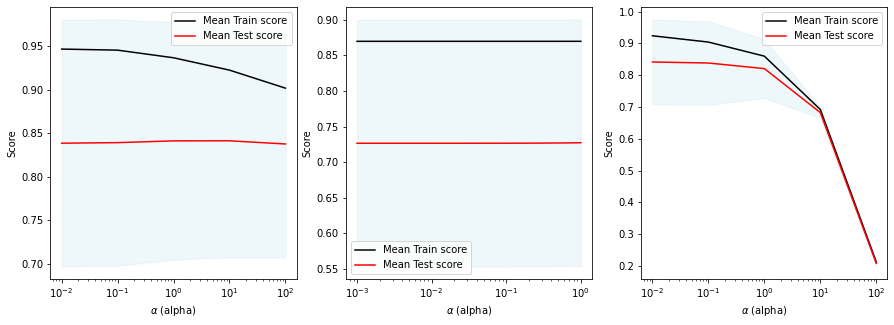

In [22]:
# Getting the scores of ridge, lasso and elastic net regression
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3)

clf1 = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('ridge', Ridge())])

clf2 = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('lasso', Lasso(tol=1))])

clf3 = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('elastic', ElasticNet())])

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ridge_param_grid = {'ridge__alpha': [0.01,0.1, 1, 10, 100]}
ridge_apha = [0.01,0.1, 1, 10, 100]


tuneParams(clf1, "Ridge", X_train, y_train, ridge_param_grid, ridge_apha, 5, ax[0])


lasso_param_grid = {'lasso__alpha': np.logspace(-3, 0, 13)}
lasso_apha = np.logspace(-3, 0, 13)


tuneParams(clf2, "Lasso", X_train, y_train, lasso_param_grid, lasso_apha, 5, ax[1])


elastic_param_grid = {'elastic__alpha': [0.01,0.1, 1, 10, 100]}
elastic_apha = [0.01,0.1, 1, 10, 100]

tuneParams(clf3, "ElasticNet", X_train, y_train, elastic_param_grid, elastic_apha, 5,ax[2])

## TASK 6- Visualize the coefficients of the resulting models. Do they agree on which features are important?


In [23]:
# Fetching top threeimportant features in ridge,lasso and elastic net regression
def get_top_three_categorical(modelPipeline, X, y, param_grid, plt, title):
    model = modelPipeline.fit(X, y)
    model_grid = get_grid_object(modelPipeline, X, y, param_grid, cv=5, return_train_score=True)
    
    
    size = len(model_grid.best_estimator_.steps[1][1].coef_)

    #Plotting scatter plots to visualize each of the feature trends
    plt.scatter(np.linspace(1,100,size),model_grid.best_estimator_.steps[1][1].coef_,c=np.sign(model_grid.best_estimator_.steps[1][1].coef_), cmap="bwr_r")
    plt.set_title(title)

    # Absoulte coefficient values for ridge, lasso and elastic net
    coeff = np.argsort(np.absolute(model_grid.best_estimator_.steps[1][1].coef_))
    featureList = preprocessor1.transformers_[1][1].named_steps.encoder.get_feature_names(cat_features);
    top_three = [i for i in coeff if i < len(featureList)]
    print(title)
    print("The first important feature is: " + featureList[top_three[0]])
    print("The second important feature is: " + featureList[top_three[1]])
    print("The third important feature is: " + featureList[top_three[2]])




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Ridge Coefficients
The first important feature is: Heating QC_Po
The second important feature is: Heating_GasA
The third important feature is: Condition 1_Artery


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Lasso Coefficients
The first important feature is: Garage Type_BuiltIn
The second important feature is: Sale Condition_Partial
The third important feature is: Garage Qual_Fa


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8285200868.955261, tolerance: 1101557990.5634878
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1571402980.3691406, tolerance: 1021374721.1038481
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1355905472.2009277, tolerance: 1043585716.0234337
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1295441

ElasticNet Coefficients
The first important feature is: Heating_GasA
The second important feature is: Misc Feature_Othr
The third important feature is: Foundation_Wood


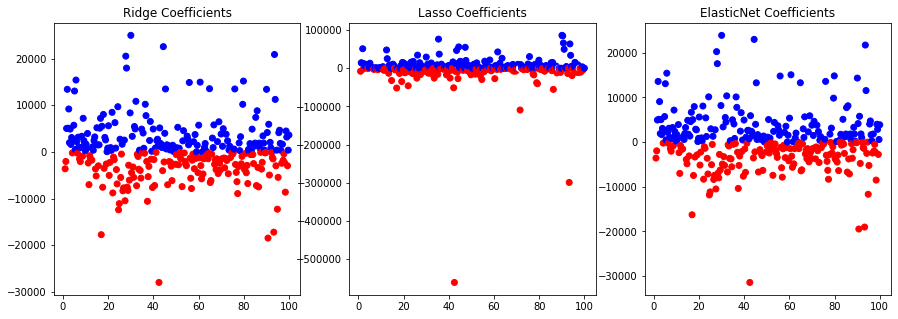

In [24]:
# Visulizing the features by subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

get_top_three_categorical(clf1, X_train, y_train, ridge_param_grid, ax[0], 'Ridge Coefficients')
get_top_three_categorical(clf2, X_train, y_train, lasso_param_grid, ax[1], 'Lasso Coefficients')
get_top_three_categorical(clf3, X_train, y_train, elastic_param_grid, ax[2], 'ElasticNet Coefficients')

Conclusion-

Ridge and Elastic Net have similar trend with feature values. The largest set of coefficient values can be found in lasso regression.

Thus, all this model agree on the most important features.